In [1]:
from shapely.errors import ShapelyDeprecationWarning

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()) + '/helpers')

import data_helper
from data_wrapper import DataWrapper
import warnings
import geopandas as gpd
import pandas as pd
import contextily as cx

# Data collection and preparation

This notebook is intended to be run as a script for data preparation. Prerequisites are that a folder with the same as specified in `version` exists in the directory linked to in `data-path.txt`. This folder must contain a KYUC survey export file named `{version}_kyuc-export.csv` with Bike Citizens token that grant access to track geometries. Tracks from files in a folder `tracks`---one file per token---in the version directory will be loaded. If `download_missing_tracks=True` is specified, tracks from missing tokens will be downloaded and stored.

In [3]:
with open('data-path.txt') as f:
    data_path = f.read()
version = '2022-08-02_20-02-15'
dw = DataWrapper(version, data_path)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=ShapelyDeprecationWarning)
    dw.load_version(
        download_missing_tracks=False
        #download_missing_tracks=True
    )

2022-08-02 23:31:11,264                 [INFO ] Loading tracks from 464 files


  0%|          | 0/464 [00:00<?, ?it/s]

These are raw data of users' total tracks which need to be cleaned and restricted to the study's specifications. The reduction in observations is recorded.

In [5]:
# To be filled with tuples containing before/after counts of observations
reductions = {}

Bike Citizens makes a determination whether a track is a valid cycling track based on various characteristics, including duration, distance, and average speed. The first step is to filter out any tracks that do not meet these criteria.

In [8]:
reductions['not_bike_tracks'] = dw.tracks.shape[0]
dw.tracks = dw.tracks[~dw.tracks.is_not_a_bike_track]
reductions['not_bike_tracks'] = (reductions['not_bike_tracks'], dw.tracks.shape[0])

Second, tracks are to be restricted to the specified time span of the study. This is the time span ethical approval was granted for and which users consented to.

In [9]:
reductions['timespan'] = dw.tracks.shape[0]
dw.tracks = dw.tracks[dw.tracks.start_time.between(pd.to_datetime('2017-07-01T00:00:00+02:00').to_numpy(), pd.to_datetime('2022-06-30T23:59:59+02:00').to_numpy())]
reductions['timespan'] = (reductions['timespan'], dw.tracks.shape[0])

Third, only tracks in Vienna are of interest to the study. A track is considered relevant if it has at least one point within the administrative area of the City of Vienna, and no point more than 50 kilometres outside of it. This allows for commuting tracks and joyrides to remain in the data set, but excludes longer cycling tours which are not of interest in this study.  District boundaries of Vienna can be obtained in various file formats from Austria's Open Data platform: [https://www.data.gv.at/katalog/dataset/stadt-wien_bezirksgrenzenwien](https://www.data.gv.at/katalog/dataset/stadt-wien_bezirksgrenzenwien)

In [10]:
district_boundaries = gpd.read_file('../geo_data/BEZIRKSGRENZEOGD.json')

<AxesSubplot:>

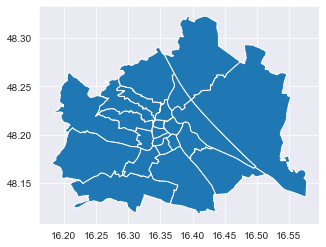

In [11]:
district_boundaries.plot()

In [12]:
reductions['area'] = dw.tracks.shape[0]
dw.tracks = data_helper.restrict_tracks(
    dw.tracks,
    must_intersect=(district_boundaries.unary_union, district_boundaries.crs),
    must_be_within=(district_boundaries.to_crs(32634).unary_union.buffer(30000), 32634)
)
reductions['area'] = (reductions['area'], dw.tracks.shape[0])

This results in the following:

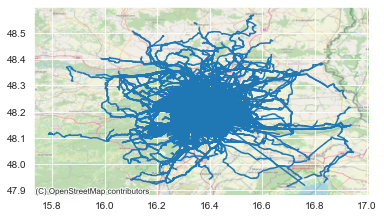

In [13]:
ax = dw.tracks.plot()
cx.add_basemap(ax, crs=dw.tracks.crs, source=cx.providers.OpenStreetMap.Mapnik)

In [14]:
reductions

{'not_bike_tracks': (134469, 134469),
 'timespan': (134469, 132844),
 'area': (132844, 125279)}

In [15]:
dw.tracks.shape

(125279, 21)

In [16]:
dw.tracks.token.unique().shape[0]

439

In [ ]:
dw.tracks[['version', 'tags_version', 'name_version', 'is_favorite_version']] = dw.tracks[['version', 'tags_version', 'name_version', 'is_favorite_version']].astype(str)

In [17]:
dw_10pc = DataWrapper(dw.version, dw.dh.data_folder_path)
dw_10pc.tracks = dw.tracks.sample(frac=.1, random_state=17)
dw_10pc.save_tracks_as_single_file('Vienna_2017-2022_10pc')

In [18]:
dw.save_tracks_as_single_file('Vienna_2017-2022')